In [21]:
import os
import time
import math
import bisect
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import t, ttest_ind
from collections import Counter
import warnings
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter, OrderedDict
warnings.simplefilter('ignore')
%matplotlib inline

In [11]:
def epoch(ts):
    """
    convert the daytime into epochtime
    """
    
    pattern = '%d-%m-%Y'
    epochtime = int(time.mktime(time.strptime(ts, pattern)))
    
    return epochtime

#def time_log(line):
#    start = line.rfind("(")+1
#    middle = line.rfind(",")
#    end = line.rfind(")")
#    t1 = epoch(line[start:middle])
#    t2 = epoch(line[middle+1:end])
#    tr = [t1,t2]
    
#    return tr

def time_diff(ts, te):
    """
    compute time difference between two time nodes
    
    input
    -----------------
    ts, te: string of day-time (dd-mm-yy')
    
    return
    -----------------
    time_diff: time difference
    """
    
    t1_y = int(ts.split("-")[0])
    t1_m = int(ts.split("-")[1])
    t1_d = int(ts.split("-")[2])
        
    #yyyy-mm-dd
    
    t2_y = int(te.split("-")[0])
    t2_m = int(te.split("-")[1])
    t2_d = int(te.split("-")[2])   
    
    d1 = date(t1_y, t1_m, t1_d)
    d2 = date(t2_y, t2_m, t2_d)
    delta = d1 - d2
    time_diff = abs(delta.days)
    
    return time_diff

def real_sol():
    """
    correct solution for the tasks in this experiment
    """
    
    sol ={}
    l1 = ['flood,Colorado,2013-09-09','blizzard,New York,2014-02-11','hurricane,North Carolina,2014-07-01']
    l2 = ['tornado,Oklahoma,2013-05-20','blizzard,Massachusetts,2014-02-06','earthquake,California,2014-08-24']    
    l3 = ['hurricane,Florida,2013-06-09','earthquake,California,2014-03-17','blizzard,New York,2014-11-13', 
          'flood,Florida,2013-06-09']
    sol['pos1,pos7,pos6'] = l1
    sol['pos4,pos9,pos5'] = l2
    sol['pos2,pos3,pos8'] = l3
    
    return sol

In [12]:
def total_log_initial():
    """
    initializing a dict to save all log results
    
    output
    -----------------
    total_dict: empty dict
    
    """    
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag','checking_tweet',
                'checking_filter', 'time_elapsed', 'actions']
    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_deviation']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    keylist = []
    for algo in algolist:
        for data in datalist:
            keylist.append((algo, data))
    
    total_dict = {}
    
    for field in fieldlist:
        total_dict[field] = {} 
        total_dict[field]['x'] = {}
        for algo in algolist:
            for key in keylist:             
                total_dict[field]['x'][key] = []
        for y in ylist:
            total_dict[field][y] = {}
            for key in keylist:            
                total_dict[field][y][key] = []

    return total_dict

def total_log_writing(total_dict, log_dict):
    """
    writing each log's dict into total dict
    
    input
    -----------------
    total_dict: current total dictionary result
    log_dict: current log dictionary result     
    
    output
    -----------------
    total_dict: new total dictionary result
    """ 
    
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                'checking_filter','time_elapsed', 'actions']
    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_deviation']
    
    algo = log_dict['algo']
    data = log_dict['data']
    key = (algo, data)
    
    for f in fieldlist:
        unnorm_x = log_dict[f]['x']
        if(len(unnorm_x)!=0):
            total_dict[f]['x'][key].append(unnorm_x)
        
        for y in ylist:            
            total_dict[f][y][key].append(log_dict[f][y])
    
    return total_dict

In [13]:
def each_log(logDir, logFile, real_sol, action):
    """
    log file parsing 
    
    input
    -----------------
    logDir: log directory; logFile: name of logfile; real_sol: correct solution
    action: True for invidual action (This will add ending value of metric in each invidual action)
            False for global field-time_elapsed and actions
    output
    -----------------
    log_dict: new log_dict with current effort
    
    """    
    
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                 'checking_filter', 'time_elapsed', 'actions']    
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_deviation'] 
    
    log_dict = {} # save log infor
    nds = []
    locations = [] 
    ndtimes = []    
    
    for field in fieldlist:
        log_dict[field] = {}
        log_dict[field]['x'] = []
        for y in ylist:
            log_dict[field][y] = []
            
    log = logDir + logFile

    with open(log, "r") as f:
        i = 0
        ts = 0
        tsq = 0
        tq = 0
        algo = 'good'
        data = 'good'
        
        for line in f:
            i += 1
            line_split = line.split('\t')
            
            if('START' in line_split[1]):               
                algo = line_split[2]
                data = line_split[-1][:-1]
                log_dict['algo']= algo
                log_dict['data']= data
                sol = real_sol[data]
                ts = float(line_split[0])/1000
                
            elif('Query_Execution' in line_split[1]):
                teq = float(line_split[0])/1000
                tq += (teq - tsq)
            
            elif('query' in line_split[1]):
                xkey = 'query'
                tsq = float(line_split[0])/1000
                time_com = tsq - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                    
            elif('slider' in line_split[1]):
                xkey = 'slider'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                
            elif('ZoomLevel' in line_split[1]):
                xkey = 'ZoomLevel'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)                
            
            elif('MouseDrag' in line_split[1]):
                xkey = 'MouseDrag'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
            
            elif('clicking_tweet' in line_split[1]):
                xkey = 'checking_tweet'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
                                    
            elif(('clicking_bbox' in line_split[1]) or ('adding_filter' in line_split[1])
                 or ('removing_filter' in line_split[1])):
                xkey = 'checking_filter'
                time_com = float(line_split[0])/1000 - ts - tq                
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)   
                
            elif('final_answer' in line_split[1]):
                nds.append(line_split[3])
                ndtimes.append(line_split[5])
                locations.append(line_split[7][:-1])
                time_com = float(line_split[0])/1000 - ts - tq
                if(action):
                    #adding end value of metric in each invidual action
                    for xkey in fieldlist[:-2]:
                        log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                else:
                    log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                
        f.close()
    
    return log_dict

In [14]:
def each_effort(log_dict, algo, data, xkey, time, nd_list, location_list, nd_time, sol):
    """
    write each effort's result into log_dict
    1st level of keys in log_dict: actions, time_elapsed, query and other actions
    2nd level of keys in log_dict: 'x', nd_precision and other metric
    The value of log_dict is a nested list for different users' result
    
    input
    -----------------
    log_dict: previous log_dict; algo: string of algorithm ('kmeans'); data: string of data ('pos1,pos7,pos6');
    xkey: string of 1st level key in log_dict; time: behavior epoch time in log file 
    nd_list, location_list, nd_time: current user's answer(list); sol: correct solution
    
    output
    -----------------
    log_dict: new log_dict with current effort
    
    """
    
    
    # log effort part: the list with 'x' is used for x-value in plots
    if(len(log_dict['actions']['x'])== 0):
        log_dict['actions']['x'].append(1)
    else:
        log_dict['actions']['x'].append(log_dict['actions']['x'][-1]+1)
    
    log_dict['time_elapsed']['x'].append(time)     
    
    if(len(log_dict[xkey]['x'])!=0):
        log_dict[xkey]['x'].append(log_dict[xkey]['x'][-1]+1)
    else:
        log_dict[xkey]['x'].append(1)
    
    
    # log results part
    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_deviation']
    
    nd_sol = [x.split(',')[0] for x in sol]
    location_sol = [x.split(',')[1] for x in sol]
    ndtime_sol = [x.split(',')[2] for x in sol]
    # log result part
    
    nd_p = 0.000
    nd_r = 0.000
    location_p = 0.000
    location_r = 0.000
    time_err = 2190.000
    #time_err = 0.000
    
    if(len(nd_list)!=0):
        nd_corr = 0
        location_corr = 0
        time_err_current = 0.000
        for i in range(len(nd_list)):
            if(nd_list[i] in nd_sol):
                nd_corr += 1
            if(location_list[i] in location_sol):
                location_corr += 1
            if((nd_list[i] in nd_sol) and (location_list[i] in location_sol)): 
                k = nd_sol.index(nd_list[i])
                time_err_current += time_diff(nd_time[i], ndtime_sol[k]) - 730
            #if((nd_list[i] in nd_sol) and (location_list[i] in location_sol)): 
            #    k = nd_sol.index(nd_list[i])
            #    time_err_current += time_diff(nd_time[i], ndtime_sol[k])
            #else:
            #    time_err_current += 730
        
        nd_p = float(nd_corr)/len(nd_list)
        nd_r = float(nd_corr)/3.0
        
        location_p = float(location_corr)/len(location_list)
        location_r = float(location_corr)/3.0
        
        time_err += time_err_current
    
    log_dict[xkey]['nd_precision'].append(nd_p)
    log_dict['actions']['nd_precision'].append(nd_p)
    log_dict['time_elapsed']['nd_precision'].append(nd_p)
    log_dict[xkey]['nd_recall'].append(nd_r)
    log_dict['actions']['nd_recall'].append(nd_r)
    log_dict['time_elapsed']['nd_recall'].append(nd_r)
    
    log_dict[xkey]['location_precision'].append(location_p)
    log_dict['actions']['location_precision'].append(location_p)
    log_dict['time_elapsed']['location_precision'].append(location_p)
    log_dict[xkey]['location_recall'].append(location_r)
    log_dict['actions']['location_recall'].append(location_r)
    log_dict['time_elapsed']['location_recall'].append(location_r)   
    
    log_dict[xkey]['nd_time_deviation'].append(time_err)
    log_dict['actions']['nd_time_deviation'].append(time_err)
    log_dict['time_elapsed']['nd_time_deviation'].append(time_err)
    
    
    return log_dict

In [15]:
def interp(X, Y, long_X):
    """
    interpolate or extrapolate for miss X in long_X
    
    output
    -----------------
    y_eval: list of Y with the same size of long_X
    
    """ 
    
    xs = set(X)
    xp = list(long_X - xs) #Note long_X is Set
    y_eval = [float(0.000)]*len(Y)
    if(len(Y)!= 0):
        yp = np.interp(xp, X, Y)
        y_eval = [yv for _,yv in sorted(zip(X,Y)+zip(xp, yp))]
    
    return y_eval

def polation(total_dict):
    """
    interpolate or extrapolate for total_dict
    
    output
    -----------------
    pol_dict: a brand_new dict with interpolation or extrapolation treatment
    
    """ 
    pol_dict = total_log_initial()
    
    fieldlist = ['time_elapsed', 'actions', 'query', 'slider', 'ZoomLevel', 'MouseDrag',
                 'checking_tweet','checking_filter']  
    ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_deviation']
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    for y in ylist:     
        for f in fieldlist:
            for algo in algolist:
                keylist = []                
                for data in datalist:
                    keylist.append((algo, data))              
                unflatten_x = []
                unflatten_y = []
                for key in keylist:
                    lx = total_dict[f]['x'][key]
                    ly = total_dict[f][y][key]
                    unflatten_x += lx
                    unflatten_y += ly

                unflatten_x = filter(None, unflatten_x)
                unflatten_y = filter(None, unflatten_y)  #remove empty nested-list 
                
                if (len(unflatten_x)!=0):
                    x_plot_set = set(reduce(lambda x1,x2: x1+x2,unflatten_x))
                    x_plot = list(x_plot_set)
                    x_plot.sort()
                    pol_dict[f]['x'][key] = x_plot

                    y_total = []
                    for j in range(len(unflatten_x)):
                        y_total_current = interp(unflatten_x[j], unflatten_y[j], x_plot_set)
                        y_total.append(y_total_current)
                    #    if(len(y_total[0])!= len(y_total_current)):
                    #        print len(y_total_current)
                    pol_dict[f][y][key] = y_total
                                      
    
    return pol_dict

In [16]:
def plot_algo_y(total_dict, filename, field_plots, user):
    """
    plotting value in total_dict into pdf file
    
    input
    -----------------
    filename: pdf file name; field_plots: "global" for time_elapsed and actions
    user: True for individual user plotting
    """     
    
    if(field_plots== "global"):
        fieldlist = ['time_elapsed']
    else:
        fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet','checking_filter']   
    
    #ylist = ['nd_precision', 'nd_recall', 'location_precision', 'location_recall','nd_time_deviation']
    ylist = ['nd_recall','location_recall','nd_time_deviation']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    color_algo = ['blue','green','red']
    
    k = 1
    pp = PdfPages(filename)
    for y in ylist:     
        for f in fieldlist:
            fig = plt.figure(k)
            ax = plt.axes()
            ax.grid(True)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            for i in range(len(algolist)):
                algo = algolist[i]
                if not ((algo=='baseline') and (f=='checking_filter')):
                    keylist = []                
                    for data in datalist:
                        keylist.append((algo, data))
                    for key in keylist:
                        lx = total_dict[f]['x'][key]
                        ly = total_dict[f][y][key]
                        
                        if(len(lx)!=0):
                            ym = np.mean(ly, axis = 0, dtype = float)
                            ym[0] = 0.00

                            if (y == "nd_time_deviation"):
                                ym[0] = 2190.00                       

                            if(user):
                                plt.plot(lx, ym, linestyle='-', color=color_algo[i])                             
                                for kk in range(len(ly)):
                                    plt.plot(lx, ly[kk], linestyle=':', color=color_algo[i]) 

                            else:
                                plt.plot(lx, ym, linestyle='-', color=color_algo[i], label=algo)
                                ys = np.std(ly, axis= 0, dtype=float)

                                df = len(ly)-1
                                confidence = 0.95
                                ts = t.ppf(1-(1 - confidence)/2.0, df)
                                yi = ts * ys/math.sqrt(df)

                                yl = ym - yi
                                yu = ym + yi
                                
                                # My code to output results
                                out=[]                                
                                out.append(array(lx))
                                out.append(ym)
                                out.append(yl)                                
                                out.append(yu)                                
                                df = pd.DataFrame(out)
                                df = df.transpose()
                                df.to_csv(algo+'_'+y+'.txt', header=None, index=None, sep='\t', mode='a')
                                
                                
                                
                                plt.fill_between(lx, yl, yu, alpha=0.1, edgecolor='', 
                                                 facecolor=color_algo[i], linewidth=0.0)                            
                            
            plt.title(f + ' VS '+ y)
            if (f == "time_elapsed"):
                plt.xlabel(f + " (Sec)")
            else:
                plt.xlabel(f)
            if (y == "nd_time_deviation"):
                plt.ylabel(y + " (Day)")
                ax.set_ylim([0, 2500])                 
            else:
                plt.ylabel(y)
                ax.set_ylim([0.0,1.2])                
            plt.legend(ncol = 3)
            k+= 1
            
            plt.savefig("plots/"+f+"_"+y+".pdf", format='pdf')
            plt.savefig(pp, format='pdf')
            plt.show()
            
            
            
           

    
    plt.close("all")
    pp.close()

In [50]:
def answer_level(r):
    l = 0
    if (r > 0.33) and (r < 0.66):
        l = 1
    elif (r > 0.66) and (r < 0.9):
        l = 2
    elif (r > 0.99):
        l = 3

    return l

def plot_algo_stage(total_dict, filename, tk):
    """
    plotting for performance distribution for different algorithms at different stage
    """
    
    xlist = ['time_elapsed']
    ylist = ['nd_recall', 'location_recall','nd_time_deviation']
    #ylist = ['nd_recall', 'location_recall']
    algolist = ['filters','kmeans','baseline']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    highlight = ["mean","median"]
    
    pp = PdfPages(filename)
    
    s = 1.0/tk
    up_time = 1200
    up_actions = 480
    k = 1
    t = 0
    for x in xlist:
        for y in ylist:
            data_bar = OrderedDict()
            vplot_data = OrderedDict()
            for i in np.linspace(s, 1.0, tk):
                if(x == 'time_elapsed'):
                    t = i*up_time
                else:
                    t = i*up_actions                    
                    
                for algo in algolist:
                    data_bar[algo] = [0, 0, 0, 0]
                    vplot_data[algo] = []
                    keylist = []                
                    for data in datalist:
                        keylist.append((algo, data))
                    for key in keylist:
                        lx = total_dict[x]['x'][key]                        
                        ly = total_dict[x][y][key]
                        
                        if(len(lx)!=0):
                            # directly get y value if target is in xlist                        
                            if (t in lx):
                                ind = lx.index(t)
                                for l in ly:
                                    yv = l[ind]
                                    vplot_data[algo].append(yv)
                                    data_bar[algo][answer_level(yv)] += 1

                            # search two nearest elements for interpolation if target is not in xlist
                            else:
                                ub = bisect.bisect(lx, t)
                                # ub == len(lx) if (t >= lx[-1])
                                if(ub == len(lx)):
                                    for l in ly:
                                        yv = l[ub-1]                                        
                                        vplot_data[algo].append(yv)
                                        data_bar[algo][answer_level(yv)] += 1                                    
                                        
                                else:
                                    xmax = lx[ub]
                                    xmin = lx[ub-1]
                                    for l in ly:
                                        ymax = l[ub]
                                        ymin = l[ub-1]
                                        yv = np.interp(t, [xmin, xmax], [ymin, ymax])
                                        vplot_data[algo].append(yv)
                                        data_bar[algo][answer_level(yv)] += 1                                       
                        
                        #if(len(lx)!=0):
                        #    xt = lx[int(i*len(lx))-1]
                        #    for l in ly:
                        #        vplot_data[algo].append(l[int(i*len(lx))-1])

                fig = plt.figure(k)
                k+= 1
                ax = plt.axes()
                #ax.grid(True)
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                
                if (y=='nd_time_deviation'):
                    labels, data = vplot_data.keys(), vplot_data.values()
                    plt.boxplot(data, meanline=False)
                    medians = np.percentile(data, 50, axis=1)
                    means =  np.mean(data, dtype = float, axis=1)
                    inds = np.arange(1, len(medians) + 1)
                    ax.scatter(inds, medians, marker='o', color='red', label = "median")
                    ax.scatter(inds, means, marker='o', color='black', label = "mean")

                    plt.legend(ncol=2)
                    plt.xticks(range(1, len(labels) + 1), labels)
                    plt.ylabel('time_deviation (Day)')
                    plt.yticks(np.arange(0, 3000, 500))                
                    if(x == 'time_elapsed'):                
                        plt.title('time_deviation VS algorithms at '+str(int(t))+' seconds')
                    else: 
                        plt.title('time_deviation VS algorithms at '+str(int(t))+' actions')              
                    plt.show()
                    # My code to output results                              
                    df = pd.DataFrame(vplot_data.values())
                    df = df.transpose()
                    df.to_csv(y+"_"+x+"_"+str(int(t))+'.txt', header=None, index=None, sep='\t', mode='a')
                
                else:
                    ########
                    ## box plot for recall
                    ########
                    
                    labels, data = vplot_data.keys(), vplot_data.values()
                    plt.boxplot(data, meanline=False)
                    medians = np.percentile(data, 50, axis=1)
                    means =  np.mean(data, dtype = float, axis=1)
                    inds = np.arange(1, len(medians) + 1)
                    ax.scatter(inds, medians, marker='o', color='red', label = "median")
                    ax.scatter(inds, means, marker='o', color='black', label = "mean")

                    plt.legend(ncol=2)
                    plt.xticks(range(1, len(labels) + 1), labels)
                    plt.yticks(np.arange(0, 1.3, 0.1))  
                    
                    yt = y.split("_")[0]

                    if(x == 'time_elapsed'):                
                        plt.title(yt+' recall VS algorithms at '+str(int(t))+' seconds')
                    else: 
                        plt.title(yt+' recall VS algorithms at '+str(int(t))+' actions')  

                    plt.show(5)   
                    
                    
                    
                    #print vplot_data.values()
                    # My code to output results                              
                    df = pd.DataFrame(vplot_data.values())
                    df = df.transpose()
                    df.to_csv(y+"_"+x+"_"+str(int(t))+'.txt', header=None, index=None, sep='\t', mode='a')
                    
                    
                    
                    
                    
        
    plt.close("all")
    pp.close()
    
    print k

In [51]:
log_dir = "experiment_logs/"
#log_dir = "one_log/"
rs = real_sol()

#pdfname = "plots_actions.pdf"
#total_dict = total_log_initial()
#for filename in os.listdir(log_dir):
#    one_dict = each_log(log_dir, filename, rs, True)
#    total_dict = total_log_writing(total_dict, one_dict)
#plot_algo(total_dict, pdfname, "actions", False)

total_dict = total_log_initial()
for filename in os.listdir(log_dir):
    #print filename
    one_dict = each_log(log_dir, filename, rs, False)
    total_dict = total_log_writing(total_dict, one_dict)
pol_dict = polation(total_dict)


pdfname = "plots_global.pdf"

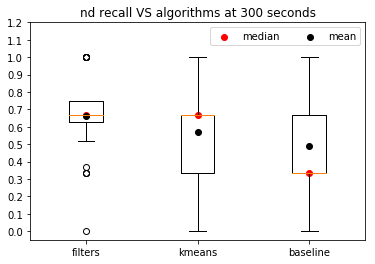

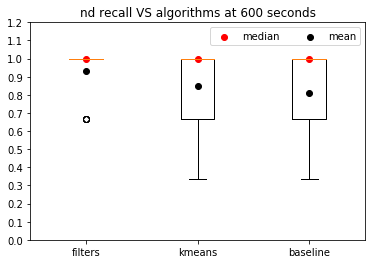

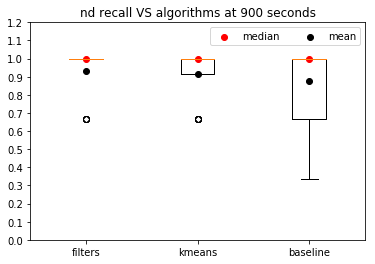

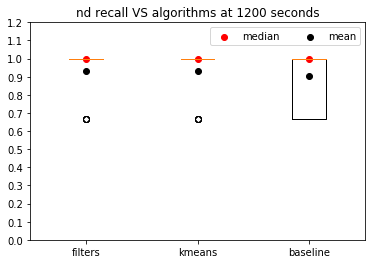

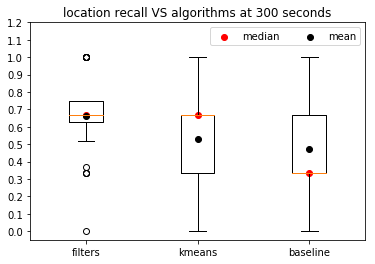

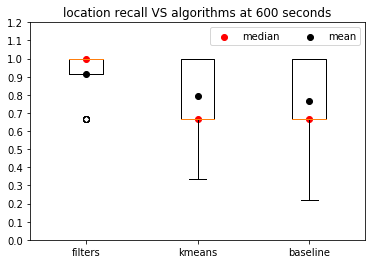

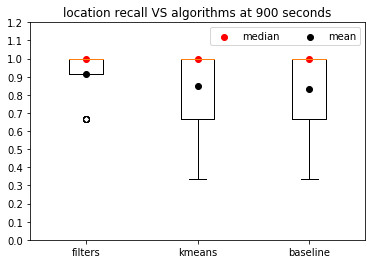

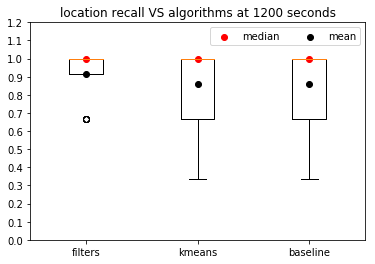

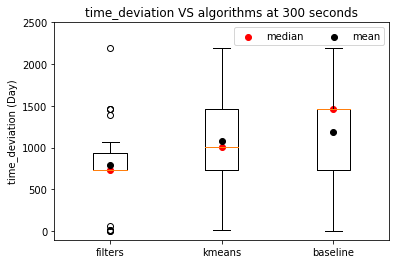

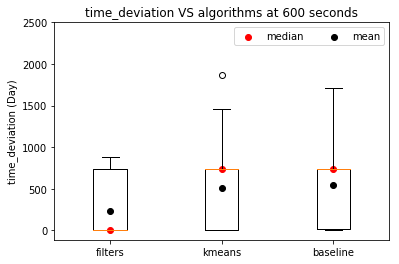

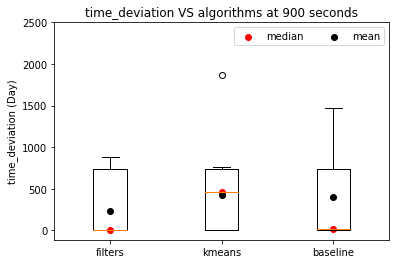

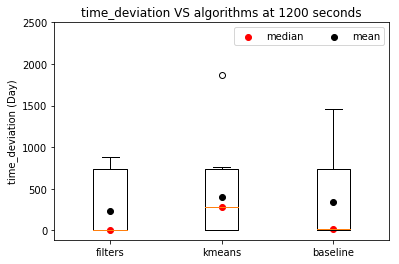

13


In [52]:
#plot_algo_y(pol_dict, pdfname, "global", False)
tk = 4

plot_algo_stage(pol_dict, pdfname, tk)